In this code I perform a stability analysis for the Lead-cooled Fast Reactor.

I use two different approaches: 

* Linearized model of the Reactor Dynamics
* Non-linear model

At the end of the code I will compare results for Open and Closed loops.

Nominal parameters employed in this work:

 
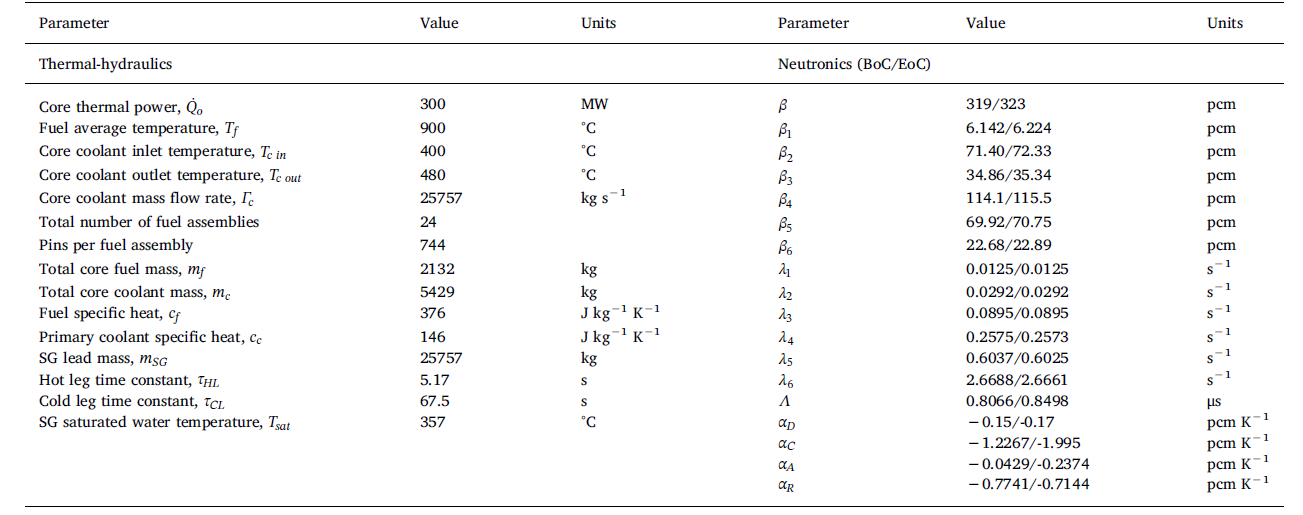

In [ ]:
import numpy as np  
from scipy import signal
import matplotlib.pyplot as plt

Inputs of the code are: 

In [ ]:
# Neutronic initial data

BetaT = 319 * 10 ** -5
Lambda = 0.8066 *10 ** -6                                                       # big Lambda [seconds]

LambdaI = np.array([0.0125, 0.0292, 0.0895, 0.2575, 0.6037, 2.6688])
Beta = 10** -5 * np.array([6.142, 71.40, 34.86, 114.1, 69.92, 22.68])           # I set the lowest values for betas, lambdas and Lambda in the range

Lambda_Avg = (np.sum(np.divide(Beta, LambdaI))/BetaT) ** (-1)

# Thermal-hydraulic initial data

P_0 = 3 * 10 ** 8                                                               #W  
T_In = 400                                                                      #C
T_Out = 480                                                                     #C
T_C = (T_In + T_Out)/2                                                          #C
T_avF = 900                                                                     #C 
DT_Core = T_avF - T_C                                                           #Difference between average Fuel and Coolant temperatures in the core


M_Fuel = 2132                                                                   #kg
C_Fuel = 376                                                                    #J/(kgK) 
M_Cool = 5429                                                                   #kg
C_Cool = 146                                                                    #J/(kgK)
G_Core = 25757                                                                  #kg/s
M_SG = 25757

Equations for the Neutron density and Precursors: 

\begin{cases} 
\begin{aligned}
  \frac{d n}{dt} &= \frac{\rho(t) - \beta}{\Lambda}n(t) + \sum\limits_{i=1}^6 \lambda_i C_i(t) \\
  \frac{d C_i}{dt} &= \frac{\beta}{\Lambda}n(t) - \lambda_i C_i(t) \\
\end{aligned}
\end{cases}

Normalization of these variables can be made in the way: 

\begin{cases}
\psi(t) = \frac{n(t)}{n_0}\\
\eta(t) = \frac{C(t)}{C_0}
\end{cases}

which leads to: 

\begin{cases}
\frac{d \psi}{dt} = \frac{\rho(t) - \beta}{\Lambda} \psi(t) + \sum\limits_{i=1}^6 \frac{\beta_i}{\Lambda} \eta_i(t) \\
\frac{d \eta_i}{dt} = \lambda_i \psi(t) - \lambda_i \eta_i(t)
\end{cases}
 
And equation for the reactivity: 

\begin{equation}
\rho(t) = \rho_{ext} + \alpha_D (T_f - T_{f_0}) + \alpha_Cd (T_c - T_{c_0}) + \alpha_A (T_f - T_{f_0}) + \alpha_R (T_c - T_{c_0}) = \\ 
 = \rho_{ext} + \alpha_f (T_f - T_{f_0}) + \alpha_c (T_c - T_{c_0})
\end{equation}

$\rho_{ext}$ can be presented in different ways:

 * $\rho_{ext} = \alpha_h \Delta H_{rod}$ \\
And usually $\alpha_h$ takes values in the range $-50 \frac{pcm}{cm} <\alpha_h < -20 \frac{pcm}{cm}$

* $\rho_{ext} = x_{rod} \cdot \beta$ , where $x_{rod} =$ [$] 


Equations for the Thermal-Hydraulic part of the problem are: 

\begin{equation}
\begin{cases}
  m_f c_f \frac{dT_f}{dt} = \dot{Q} - K_{fc} (T_f - T_c) \\
  m_c c_c \frac{dT_c}{dt} = K_{fc} (T_f - T_c) - \Gamma_c c_c (T_{c_{out}} - T_{c_{in}})\\
  K_{fc} = \frac{\dot{Q_0}}{T_f - T_c}
\end{cases}
\end{equation}

We can linearize this equations with a substitutions: 

\begin{cases} 
\begin{aligned}
  \psi(t) &= \psi_0 + \delta \psi(t) \\
  \eta_i(t) &= \eta_{i_0} + \delta \eta_i(t) \\
  \rho(t) &= \rho_0 + \delta \rho(t) \\
  T_f(t) &= T_{f_0} + \delta T_f\\
  T_c(t) &= T_{c_0} + \delta T_c
\end{aligned}
\end{cases}


Set of equations that I get for variations is:
\begin{cases}
\begin{aligned}
  \frac{d \delta \psi}{dt} &= - \frac{\beta}{\Lambda}\delta \psi(t) + \sum\limits_{i=1}^6 \frac{\beta_i}{\Lambda}\delta \eta_i(t) + \frac{\alpha_{F}}{\Lambda}\delta T_f(t) + \frac{\alpha_{C}}{\Lambda}\delta T_c(t) + \frac{\rho_{ext}}{\Lambda}\\
  \frac{d \delta \eta_i}{dt} &= {\lambda_i}\delta \psi_i(t) - {\lambda_i}\delta \eta_i(t) \\
  \frac{d \delta T_f}{dt} &= \frac{\dot{Q_0}}{m_f c_f}\delta \psi(t) - \frac{\delta T_f(t) - \delta T_c(t)}{\tau_f} \\
  \frac{d \delta T_c}{dt} &= \frac{\delta T_f(t) - \delta T_c(t)}{\tau_c} - \frac{2(\delta T_c(t) - T_{c_{in}})}{\tau_0}\\
  \delta \rho(t) &= \rho_{ext} + \alpha_F \delta T_f + \alpha_C \delta T_c
\end{aligned}
\end{cases}

where: 

\begin{cases}
\tau_f = \frac{m_f c_f}{K_{fc}}\\
\tau_0 = \frac{m_c}{\Gamma_c}\\
\tau_c = \frac{m_c c_c}{K_{fc}}
\end{cases}


In [ ]:
# Reactivity feedback coefficients (LFR)
rho_ext = 1 * 10** -5                                                          # Control Rods reactivity
 
# Assume the beginning of the cycle:
Alpha_D = - 0.15 * 10** -5                                                      #pcm/C
Alpha_Cd = - 1.2267 * 10** -5                                                   #pcm/C
Alpha_A = - 0.0429 * 10** -5                                                    #pcm/C
Alpha_R = - 0.7741 * 10** -5                                                    #pcm/C

# At the end of the cycle:
#Alpha_D = - 0.17 * 10** -5                                                      #pcm/C
#Alpha_Cd = - 1.995 * 10** -5                                                    #pcm/C
#Alpha_A = - 0.2374 * 10** -5                                                    #pcm/C
#Alpha_R = - 0.7144 * 10** -5                                                    #pcm/C

Alpha_Cool = Alpha_Cd + Alpha_R
Alpha_Fuel = Alpha_D + Alpha_A 

# Global heat transfer coefficient

K = P_0 / DT_Core #kW/C

# Characteristic time constants (fuel / coolant)

Tau_Fuel = M_Fuel * C_Fuel / K #s
Tau_Cool = M_Cool * C_Cool / K #s
Tau_0 = M_Cool / G_Core #s

Tau_HL = 5.17 #s                                                                # Hot leg delay 
Tau_CL = 67.5 #s                                                                # Cold leg delay 

print("Global heat transfer coefficient (overall): " + str(K) + " kW/C")
print("Characteristic time constant (fuel): " + str(Tau_Fuel) + " s")
print("Characteristic time constant (coolant): " + str(Tau_Cool) + " s")
print("Characteristic time constant (coolant recirculation): " + str(Tau_0) + " s")
print("alpha for fuel is " + str(Alpha_Fuel))
print("alpha for coolant is " + str(Alpha_Cool))

Global heat transfer coefficient (overall): 652173.9130434783 kW/C
Characteristic time constant (fuel): 1.2291690666666666 s
Characteristic time constant (coolant): 1.2153721333333334 s
Characteristic time constant (coolant recirculation): 0.21077765267694218 s
alpha for fuel is -1.929e-06
alpha for coolant is -2.0008000000000002e-05


# Linear Open Loop Model:

As you can see the order of the magnitude of the Characteristic time constants is lower than in the PWR reactor, because of thermal features of the lead coolant.

From the system of ODE, we can retrieve the matrices characterising the system to find the state-space representation of the system. First, we need to define the state, input and output variables:

\begin{equation}
  x = [\psi, \eta_i, T_f, T_c] \\
  u = [\rho_{ext}, T_{c_{in}}] \\
  y = [\psi, \eta_i, T_f, T_c, T_{c_{out}}, \Delta\rho]
\end{equation}

The state-space representation is:

\begin{aligned}
  \dot{x} &= Ax + Bu \\
  y &= Cx + Du
\end{aligned}

\begin{equation}
  A = \begin{bmatrix} 
-\frac{\beta}{\Lambda} & \frac{\beta_1}{\Lambda}& \frac{\beta_2}{\Lambda} & \frac{\beta_3}{\Lambda}& \frac{\beta_4}{\Lambda}& \frac{\beta_5}{\Lambda}& \frac{\beta_6}{\Lambda}& \frac{\alpha_f}{\Lambda} & \frac{\alpha_c}{\Lambda} \\
  \lambda_1 & -\lambda_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_2 & 0 &-\lambda_2 & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_3 & 0 & 0 &-\lambda_3 & 0 & 0 & 0 & 0 & 0\\
  \lambda_4 & 0 & 0 & 0 &-\lambda_4 & 0  & 0 & 0 & 0\\
  \lambda_5 & 0 & 0 & 0 & 0 & -\lambda_5 & 0 & 0 & 0 \\
  \lambda_6 & 0 & 0 & 0 & 0 & 0 &-\lambda_6 & 0 & 0 \\
  \frac{\dot{Q_0}}{M_F C_F} & 0 & 0 & 0 & 0 & 0 & 0 & -\frac{1}{\tau_F} & \frac{1}{\tau_F} \\
  0 & 0 & 0 & 0 & 0 & 0 &0 & \frac{1}{\tau_C} & -\frac{1}{\tau_C}-\frac{2}{\tau_0}\\
  \end{bmatrix}
\end{equation}

\begin{equation}
  B = \begin{bmatrix} \frac{1}{\Lambda} & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & \frac{2}{\tau_0} \\
  \end{bmatrix}
\end{equation}

\begin{equation}
  C = \begin{bmatrix} 
  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 &\alpha_F & \alpha_C \\
  \end{bmatrix}
\end{equation}

\begin{equation}
  D = \begin{bmatrix} 
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & -1 \\
  1 & 0
  \end{bmatrix}
\end{equation}

In [ ]:
# Building the system matrices [P | C | TF | TC]

# Dynamic matrix (coefficients)

A = np.array([
    [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda, Alpha_Fuel/Lambda, Alpha_Cool/Lambda], #Power density equation
    [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
    [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0], #Precursor density equation 2
    [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0], #Precursor density equation 3 
    [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0], #Precursor density equation 4
    [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0], #Precursor density equation 5
    [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0], #Precursor density equation 6
    [P_0/(M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel], #Fuel temperature equation
    [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, -1/Tau_Cool - 2/Tau_0] #Coolant temperature equation
])

# Input vector (inputs: rod movement | inlet temperature)

B = np.array([
              [(1/Lambda)*0.5*BetaT, 0], #Power density equation
              [0, 0], #Precursor density (average) equation
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0], #Fuel temperature equation
              [0, 2/Tau_0] #Coolant temperature equation
])

# Mapping matrix (outputs: P | C | TF | TC | T_Out | Reactivity contributions)

C = np.array([
              [1, 0, 0, 0, 0, 0, 0, 0, 0], #Power density
              [0, 1, 0, 0, 0, 0, 0, 0, 0], #Precursor density 1
              [0, 0, 1, 0, 0, 0, 0, 0, 0], #Precursor density 2
              [0, 0, 0, 1, 0, 0, 0, 0, 0], #Precursor density 3
              [0, 0, 0, 0, 1, 0, 0, 0, 0], #Precursor density 4
              [0, 0, 0, 0, 0, 1, 0, 0, 0], #Precursor density 5
              [0, 0, 0, 0, 0, 0, 1, 0, 0], #Precursor density 6
              [0, 0, 0, 0, 0, 0, 0, 1, 0], #Fuel temperature
              [0, 0, 0, 0, 0, 0, 0, 0, 1], #Coolant temperature (average)
              [0, 0, 0, 0, 0, 0, 0, 0, 2], #Coolant temperature (outlet)
              [0, 0, 0, 0, 0, 0, 0, Alpha_Fuel, Alpha_Cool] #Reactivity contributions
])

# Feedforward matrix (rod movement | inlet temperature)

D = np.array([
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],              
              [0, -1],
              [1*0.5*BetaT, 0]
])

In [ ]:
 # Time discretisation

t_0 = 0
t_F = 400
Dt = Lambda*1000

t = np.arange(t_0, t_F, Lambda*10**3)

In [ ]:
# State-space model

Dynamic_LFR = signal.StateSpace(A, B, C, D)

# Transfer function

TF_Rod = signal.ss2tf(A, B, C, D, input = 0) #with respect to rod movement      # we can calculate zeros of nominator and denominator 
TF_TIn = signal.ss2tf(A, B, C, D, input = 1) #with respect to inlet temperature


In [ ]:
# Unitary step response

t, Y_Rho = signal.step(TF_Rod, X0 = [0, 0, 0, 0, 0, 0, 0, 0, 0], T = t)
t, Y_Tin = signal.step(TF_TIn, X0 = [0, 0, 0, 0, 0, 0, 0, 0, 0], T = t)


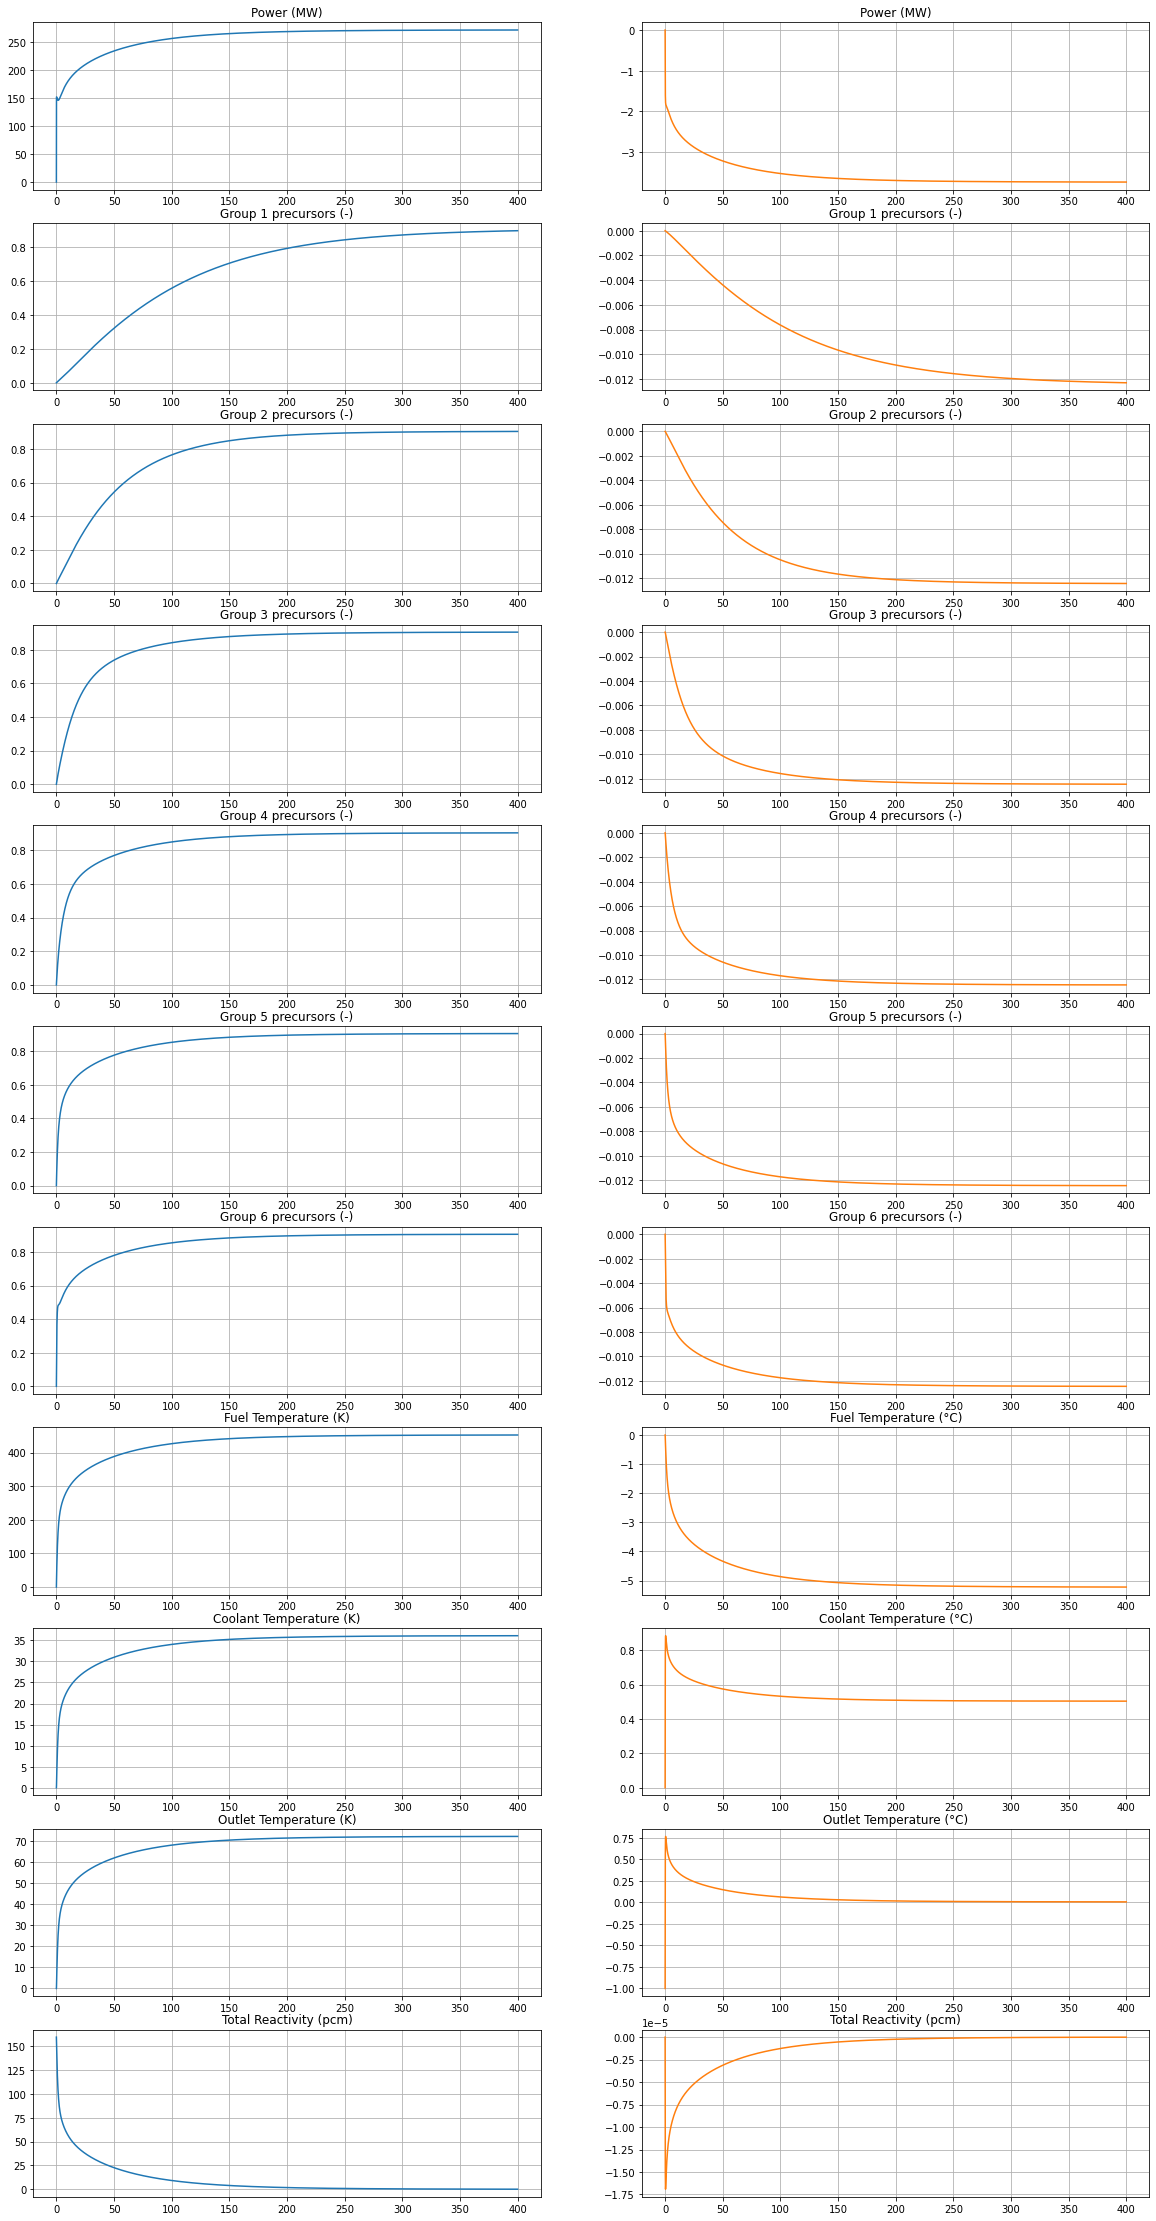

In [ ]:
fig, axs = plt.subplots(11, 2, figsize = (20, 40))

axs[0, 0].plot(t, Y_Rho[:,0] *P_0/(10**6),)
axs[0, 0].set_title('Power (MW)')
axs[0, 0].grid()
axs[1, 0].plot(t, Y_Rho[:,1],)
axs[1, 0].set_title('Group 1 precursors (-)')
axs[1, 0].grid()
axs[2, 0].plot(t, Y_Rho[:,2], )
axs[2, 0].set_title('Group 2 precursors (-)')
axs[2, 0].grid()
axs[3, 0].plot(t, Y_Rho[:,3])
axs[3, 0].set_title('Group 3 precursors (-)')
axs[3, 0].grid()
axs[4, 0].plot(t, Y_Rho[:,4],)
axs[4, 0].set_title('Group 4 precursors (-)')
axs[4, 0].grid()
axs[5, 0].plot(t, Y_Rho[:,5], )
axs[5, 0].set_title('Group 5 precursors (-)')
axs[5, 0].grid()
axs[6, 0].plot(t, Y_Rho[:,6], )
axs[6, 0].set_title('Group 6 precursors (-)')
axs[6, 0].grid()
axs[7, 0].plot(t, Y_Rho[:,7], )
axs[7, 0].set_title('Fuel Temperature (K)')
axs[7, 0].grid()
axs[8, 0].plot(t, Y_Rho[:,8],)
axs[8, 0].set_title('Coolant Temperature (K)')
axs[8, 0].grid()
axs[9, 0].plot(t, Y_Rho[:,9],)
axs[9, 0].set_title('Outlet Temperature (K)')
axs[9, 0].grid()
axs[10, 0].plot(t, Y_Rho[:,10]*10**5, )
axs[10, 0].set_title('Total Reactivity (pcm)')
axs[10, 0].grid()

axs[0, 1].plot(t, Y_Tin[:,0]*P_0/(10**6), 'tab:orange')
axs[0, 1].set_title('Power (MW)')
axs[0, 1].grid()
axs[1, 1].plot(t, Y_Tin[:,1], 'tab:orange')
axs[1, 1].set_title('Group 1 precursors (-)')
axs[1, 1].grid()
axs[2, 1].plot(t, Y_Tin[:,2], 'tab:orange')
axs[2, 1].set_title('Group 2 precursors (-)')
axs[2, 1].grid()
axs[3, 1].plot(t, Y_Tin[:,3], 'tab:orange')
axs[3, 1].set_title('Group 3 precursors (-)')
axs[3, 1].grid()
axs[4, 1].plot(t, Y_Tin[:,4], 'tab:orange')
axs[4, 1].set_title('Group 4 precursors (-)')
axs[4, 1].grid()
axs[5, 1].plot(t, Y_Tin[:,5], 'tab:orange')
axs[5, 1].set_title('Group 5 precursors (-)')
axs[5, 1].grid()
axs[6, 1].plot(t, Y_Tin[:,6], 'tab:orange')
axs[6, 1].set_title('Group 6 precursors (-)')
axs[6, 1].grid()
axs[7, 1].plot(t, Y_Tin[:,7], 'tab:orange')
axs[7, 1].set_title('Fuel Temperature (°C)')
axs[7, 1].grid()
axs[8, 1].plot(t, Y_Tin[:,8], 'tab:orange')
axs[8, 1].set_title('Coolant Temperature (°C)')
axs[8, 1].grid()
axs[9, 1].plot(t, Y_Tin[:,9], 'tab:orange')
axs[9, 1].set_title('Outlet Temperature (°C)')
axs[9, 1].grid()
axs[10, 1].plot(t, Y_Tin[:,10], 'tab:orange')
axs[10, 1].set_title('Total Reactivity (pcm)')
axs[10, 1].grid()

Dominant eigenvalues: -0.011880313597101084


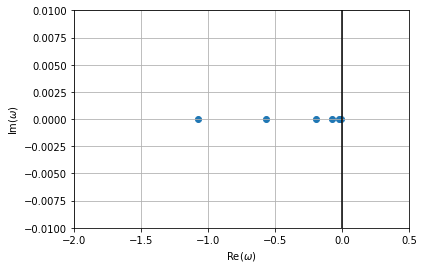

In [ ]:
# Eigenvalues computation

Eigenvalues = np.linalg.eigvals(A)

print("Dominant eigenvalues: " + str(max(np.real(Eigenvalues))))

plt.scatter(np.real(Eigenvalues),np.imag(Eigenvalues))
plt.xlabel(f'Re($\omega$)')
plt.ylabel(f'Im($\omega$)')
plt.xlim(-2, 0.5)
plt.ylim(-0.01, 0.01)
plt.vlines(0,-0.01, 0.01)
plt.grid()

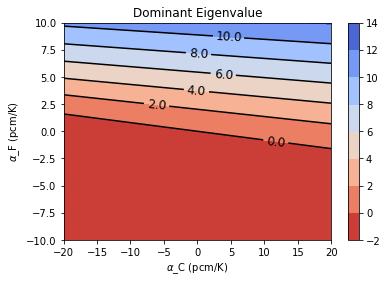

In [ ]:
# Stability map (Alpha_Fuel / Alpha_Cool)

M = 400
N = 400

X = np.zeros(M)
Y = np.zeros(N)
Map = np.zeros((M, N))

Alpha_F = np.linspace(-0.0001,0.0001,M) 
Alpha_C = np.linspace(-0.0002,0.0002,N) 


for AF in range(0, M):
  for AC in range(0, N):
    X[AC] = Alpha_C[AC] * 10 ** 5
    Y[AF] = Alpha_F[AF] * 10 ** 5

    A_Temp = np.array([
    [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda, Alpha_F[AF]/Lambda, Alpha_C[AC]/Lambda], #Power density equation
    [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
    [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0], #Precursor density equation 2
    [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0], #Precursor density equation 3 
    [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0], #Precursor density equation 4
    [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0], #Precursor density equation 5
    [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0], #Precursor density equation 6
    [P_0 / (M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel], #Fuel temperature equation
    [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, -1/Tau_Cool - 2/Tau_0] #Reactivity contributions
    ])

    Eigen = np.linalg.eigvals(A_Temp)
    MaxEigen = np.max(np.real(Eigen))
    Map[AF,AC] = MaxEigen

plt.figure()
levels = [0, 2, 4, 6, 8, 10]
contour = plt.contour(X, Y, Map, levels, colors = 'black')
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
contour_filled = plt.contourf(X, Y, Map, cmap='coolwarm_r');
plt.colorbar(contour_filled);
plt.title('Dominant Eigenvalue');
plt.xlabel(r'$\alpha$_C (pcm/K)');
plt.ylabel(r'$\alpha$_F (pcm/K)');

We can also check the asymptotic stability by computing the $L^2$ norm of the matrix exponential:
\begin{equation}
  \vert\vert \exp{At} \vert\vert_{L_2}
\end{equation}
This is important because the largest eigenvalue only gives information on stability in a Lyapunov sense (so, asymptotically). With it, we don't have any information about what happens at the beginning of the transient. The matrix exponential gives us some insights on this (in particular, it checks if we can have what is called transient growth).

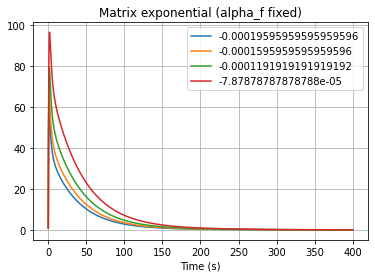

In [ ]:
from scipy import linalg

# Transient exponential matrix

Alpha_Fc = np.linspace(-0.0001,-0.00001,100) 
Alpha_Cc = np.linspace(-0.0002,0.0002,100) 
tcoarse = np.linspace(t_0,t_F,1000)

MatrixExpAC = np.zeros((len(Alpha_Cc),len(tcoarse)))

for AC in range(0, len(Alpha_Cc)):
    A_Temp = np.array([
      [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda, Alpha_Fuel/Lambda, Alpha_Cc[AC]/Lambda], #Power density equation
      [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
      [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0], #Precursor density equation 2
      [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0], #Precursor density equation 3 
      [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0], #Precursor density equation 4
      [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0], #Precursor density equation 5
      [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0], #Precursor density equation 6
      [P_0 / (M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel], #Fuel temperature equation
      [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, -1/Tau_Cool - 2/Tau_0] #Reactivity contributions
      ])


    for j in range(0,len(tcoarse)):
      MatrixExpAC[AC,j] = np.linalg.norm(linalg.expm(A_Temp*tcoarse[j]),2)

plt.plot(tcoarse,MatrixExpAC[1,:],label = str(Alpha_Cc[1]))
plt.plot(tcoarse,MatrixExpAC[10,:],label = str(Alpha_Cc[10]))
plt.plot(tcoarse,MatrixExpAC[20,:],label = str(Alpha_Cc[20]))
plt.plot(tcoarse,MatrixExpAC[30,:],label = str(Alpha_Cc[30]))
plt.xlabel('Time (s)')
plt.title(f'Matrix exponential (alpha_f fixed)')
plt.grid()
plt.legend()

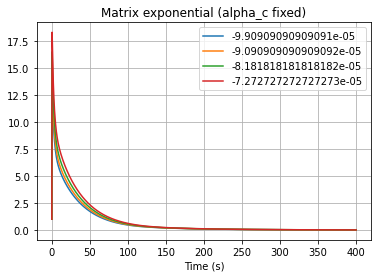

In [ ]:
MatrixExpAF = np.zeros((len(Alpha_Fc),len(tcoarse)))

for AF in range(0, len(Alpha_Fc)):
    A_Tempf = np.array([
      [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda, Alpha_Fc[AF]/Lambda, Alpha_Cool/Lambda], #Power density equation
      [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
      [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0], #Precursor density equation 2
      [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0], #Precursor density equation 3 
      [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0], #Precursor density equation 4
      [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0], #Precursor density equation 5
      [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0], #Precursor density equation 6
      [P_0 / (M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel], #Fuel temperature equation
      [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, -1/Tau_Cool - 2/Tau_0] #Reactivity contributions
      ])


    for j in range(0,len(tcoarse)):
      MatrixExpAF[AF,j] = np.linalg.norm(linalg.expm(A_Tempf*tcoarse[j]),2)

plt.plot(tcoarse,MatrixExpAF[1,:],label = str(Alpha_Fc[1]))
plt.plot(tcoarse,MatrixExpAF[10,:],label = str(Alpha_Fc[10]))
plt.plot(tcoarse,MatrixExpAF[20,:],label = str(Alpha_Fc[20]))
plt.plot(tcoarse,MatrixExpAF[30,:],label = str(Alpha_Fc[30]))
plt.xlabel('Time (s)')
plt.title(f'Matrix exponential (alpha_c fixed)')
plt.grid()
plt.legend()

# Non-linear Open Loop:

Now we solve the nonlinear system. We can check its results against the map computed above by changing the values of the two coefficients, also we can check the response of the system for different values of the input reactivity (control rod movement) / inlet temperature (possible accidental conditions).

Fuel feedback coefficient: -1.929e-06
Coolant feedback coefficient: -2.0008000000000002e-05
Inlet temperature: 400
Initial power: 300000000
Reactivity insertion (pcm): 100.0


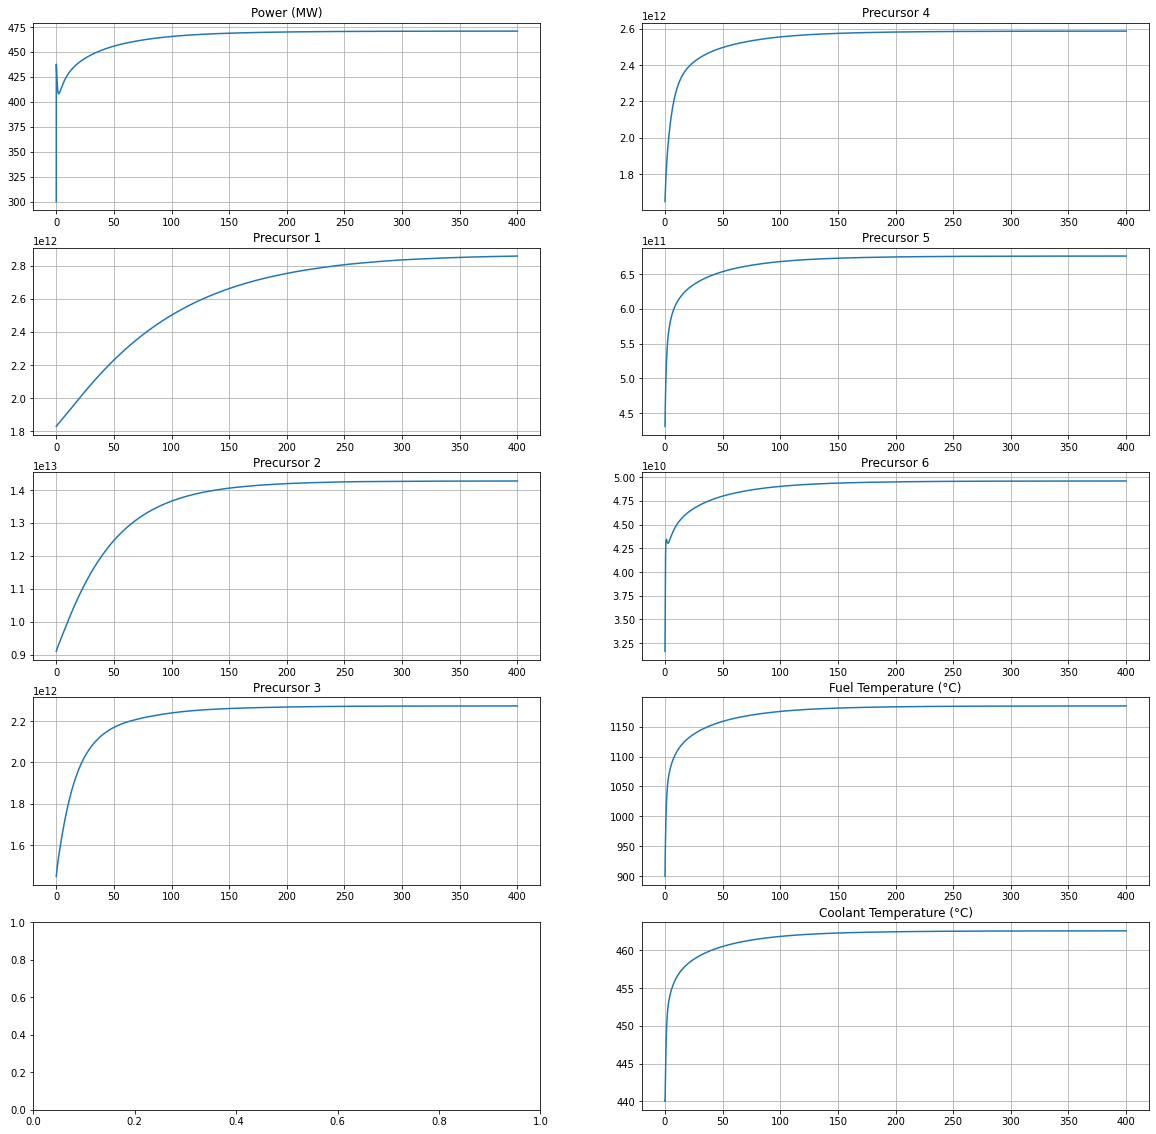

In [ ]:
# Definition of the nonlinear (6G) model

from scipy.integrate import solve_ivp

# Stationary point


TC0 = T_C
TF0 = T_avF

C_1 = P_0 / Lambda * np.divide(Beta[0], LambdaI[0])
C_2 = P_0 / Lambda * np.divide(Beta[1], LambdaI[1])
C_3 = P_0 / Lambda * np.divide(Beta[2], LambdaI[2])
C_4 = P_0 / Lambda * np.divide(Beta[3], LambdaI[3])
C_5 = P_0 / Lambda * np.divide(Beta[4], LambdaI[4])
C_6 = P_0 / Lambda * np.divide(Beta[5], LambdaI[5])
y_0 = [P_0, C_1, C_2, C_3, C_4, C_5, C_6, TF0, TC0] 

# Input

Rho_0 = 0
Rho_ext = 100*10**-5                                                           
U = [Rho_ext, T_In]

t_end = 400
tnew = np.arange(0,t_end,10**-3)

# Model

def NonLinearModel(t,y):
    dPdt = (U[0] + Alpha_Fuel*(y[7]-y_0[7]) + Alpha_Cool*(y[8]-y_0[8]) - BetaT)*y[0]/Lambda + LambdaI[0]*y[1]+LambdaI[1]*y[2]+LambdaI[2]*y[3]+LambdaI[3]*y[4]+LambdaI[4]*y[5]+LambdaI[5]*y[6]
    dC1dt = (Beta[0]/Lambda)*y[0] - LambdaI[0]*y[1]
    dC2dt = (Beta[1]/Lambda)*y[0] - LambdaI[1]*y[2]
    dC3dt = (Beta[2]/Lambda)*y[0] - LambdaI[2]*y[3]
    dC4dt = (Beta[3]/Lambda)*y[0] - LambdaI[3]*y[4]
    dC5dt = (Beta[4]/Lambda)*y[0] - LambdaI[4]*y[5]
    dC6dt = (Beta[5]/Lambda)*y[0] - LambdaI[5]*y[6]
    dTfdt = y[0]/(M_Fuel*C_Fuel) - K*(y[7]-y[8])/(M_Fuel*C_Fuel)
    dTcdt = K*(y[7]-y[8])/(M_Cool*C_Cool) - 2*G_Core*(y[8]-U[1])/(M_Cool)
    dYdt = [dPdt,dC1dt,dC2dt,dC3dt,dC4dt,dC5dt,dC6dt,dTfdt,dTcdt]
    return dYdt

Solution = solve_ivp(NonLinearModel, [t_0,t_end], y_0, method = 'BDF',t_eval = tnew)

print("Fuel feedback coefficient: " + str(Alpha_Fuel))
print("Coolant feedback coefficient: " + str(Alpha_Cool))
print("Inlet temperature: " + str(T_In))
print("Initial power: " + str(P_0))
print("Reactivity insertion (pcm): " + str(U[0]*10**5))

fig, axs = plt.subplots(5, 2, figsize = (20, 20))
axs[0, 0].plot(Solution.t, Solution.y[0]*10**-6)
axs[0, 0].set_title('Power (MW)')
axs[0, 0].grid()
axs[1, 0].plot(Solution.t, Solution.y[1])
axs[1, 0].set_title('Precursor 1')
axs[1, 0].grid()
axs[2, 0].plot(Solution.t, Solution.y[2])
axs[2, 0].set_title('Precursor 2')
axs[2, 0].grid()
axs[3, 0].plot(Solution.t, Solution.y[3])
axs[3, 0].set_title('Precursor 3')
axs[3, 0].grid()
axs[0, 1].plot(Solution.t, Solution.y[4])
axs[0, 1].set_title('Precursor 4')
axs[0, 1].grid()
axs[1, 1].plot(Solution.t, Solution.y[5])
axs[1, 1].set_title('Precursor 5')
axs[1, 1].grid()
axs[2, 1].plot(Solution.t, Solution.y[6])
axs[2, 1].set_title('Precursor 6')
axs[2, 1].grid()
axs[3, 1].plot(Solution.t, Solution.y[7])
axs[3, 1].set_title('Fuel Temperature (°C)')
axs[3, 1].grid()
axs[4, 1].plot(Solution.t, Solution.y[8])
axs[4, 1].set_title('Coolant Temperature (°C)')
axs[4, 1].grid()


# Non-Linear Closed Loop Model:

Simplified scheme of LFR primary circuit: 

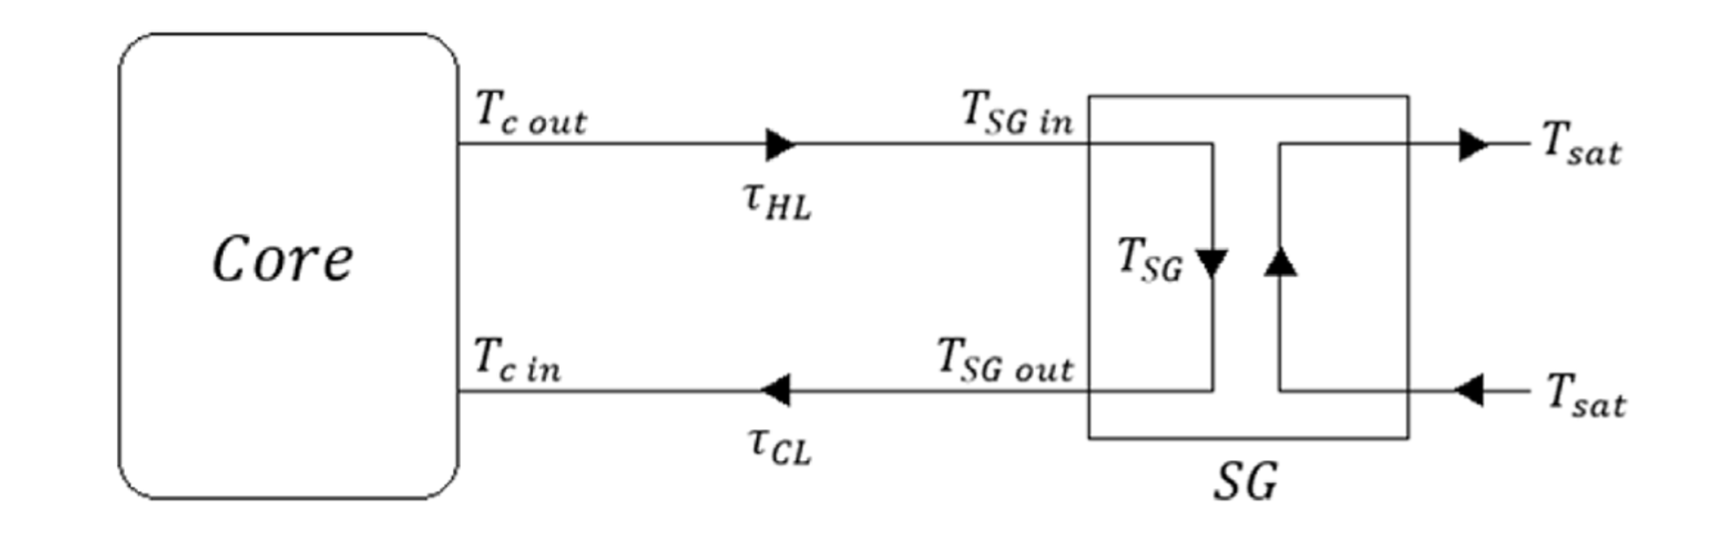

Taking into consideration Steam Generator, we will have a new set of equations: 
\begin{equation}
\begin{cases}
  m_f c_f \frac{dT_f}{dt} = \dot{Q} - K_{fc} (T_f - T_c) \\
  m_c c_c \frac{dT_c}{dt} = K_{fc} (T_f - T_c) - \Gamma_c c_c (T_{c_{out}} - T_{c_{in}})\\
  K_{fc} = \frac{\dot{Q_0}}{T_f - T_c}\\
  \frac{dT_{SG_{in}}}{dt} = \frac{1}{\tau_{HL}} (T_{c_{out}}-T_{SG_{in}}) \\
  m_{SG} c_c \frac{dT_{SG}}{dt} = - K_{SG} (T_{SG} - T_{sat}) - \Gamma_c c_c (T_{SG_{out}} - T_{SG_{in}})\\
  \frac{dT_{c_{in}}}{dt} = \frac{1}{\tau_{CL}} (T_{SG_{out}}-T_{c_{in}}) \\
\end{cases}
\end{equation}

Modifying them for the code: 

\begin{cases}
  \frac{d n}{dt} = \frac{\rho(t) - \beta}{\Lambda}n(t) + \sum\limits_{i=1}^6 \lambda_i C_i(t) \\
  \frac{d C_i}{dt} = \frac{\beta}{\Lambda}n(t) - \lambda_i C_i(t) \\
  m_f c_f \frac{dT_f}{dt} = \dot{Q} - K_{fc} (T_f - T_c) \\
  m_c c_c \frac{dT_c}{dt} = K_{fc} (T_f - T_c) - 2\Gamma_c c_c (T_{c} - T_{c_{in}})\\
  K_{fc} = \frac{\dot{Q_0}}{T_f - T_c}\\
  \frac{dT_{SG_{in}}}{dt} = \frac{1}{\tau_{HL}} (2T_{c} - T_{c_{in}}-T_{SG_{in}}) \\
  m_{SG} c_c \frac{dT_{SG}}{dt} = - K_{SG} (T_{SG} - T_{sat}) - 2 \Gamma_c c_c (T_{SG} - T_{SG_{in}})\\
  \frac{dT_{c_{in}}}{dt} = \frac{1}{\tau_{CL}} (T_{SG_{out}}-T_{c_{in}}) \\
\end{cases}


Non-linear model for this case:

In [ ]:
T_sat = 357
Tln = (T_Out - T_In)/(np.log((T_Out - T_sat)/(T_In - T_sat)))

Ksg = P_0/(Tln)
Ksg

3941190.898795706

Fuel feedback coefficient: -1.929e-06
Coolant feedback coefficient: -2.0008000000000002e-05
Saturation temperature: 357
Initial power: 300000000
Reactivity insertion (pcm): 100.0


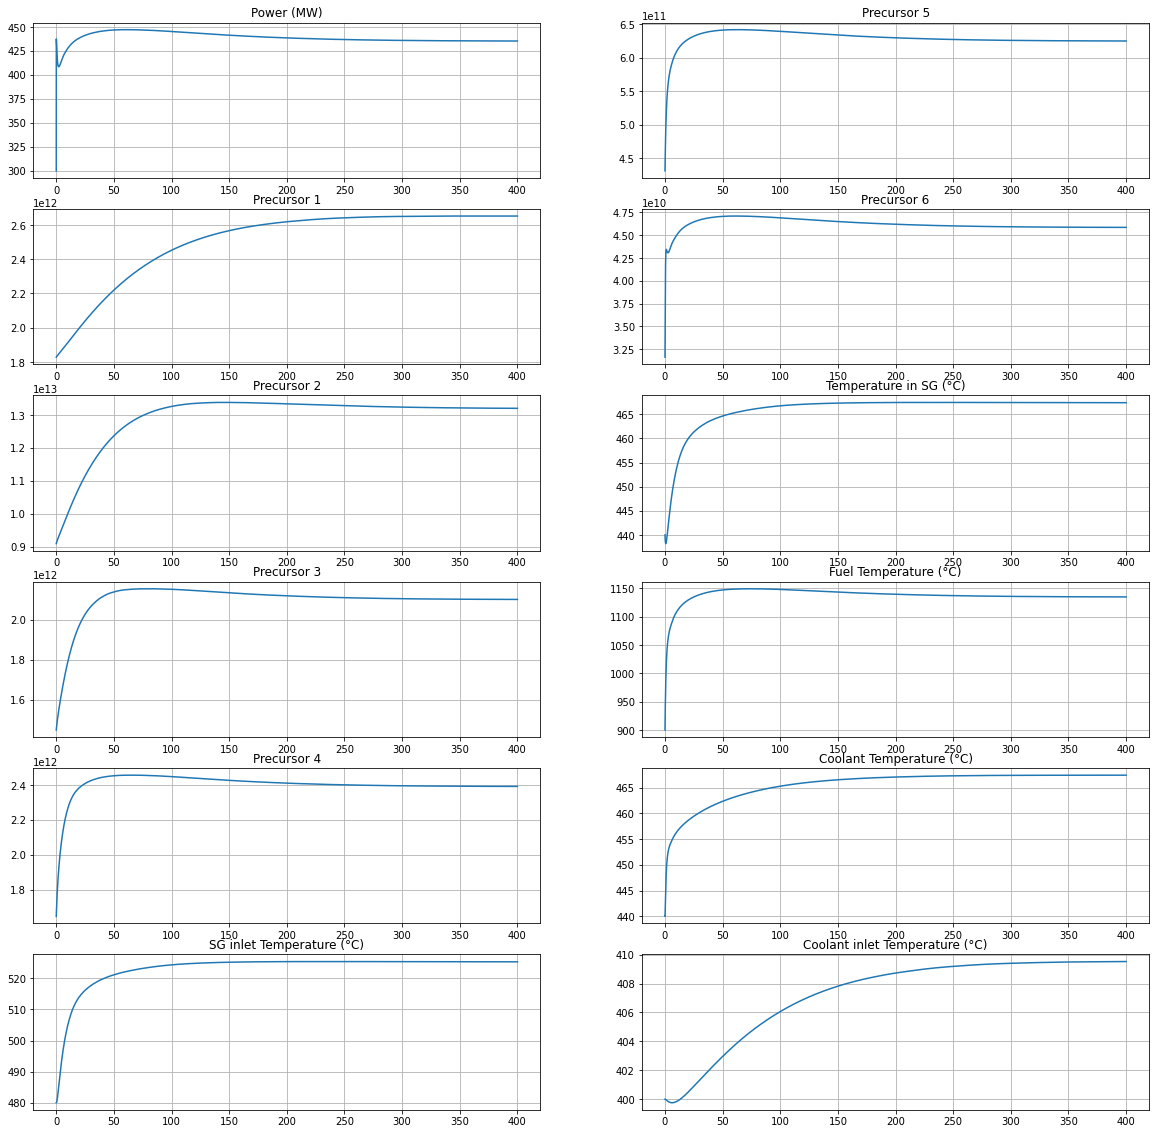

In [ ]:
# Definition of the nonlinear  model

# Stationary point

TC0 = T_C
TF0 = T_avF
T_SG0 = TC0
T_SGin = T_Out
T_Cin = T_In

C_1 = P_0 / Lambda * np.divide(Beta[0], LambdaI[0])
C_2 = P_0 / Lambda * np.divide(Beta[1], LambdaI[1])
C_3 = P_0 / Lambda * np.divide(Beta[2], LambdaI[2])
C_4 = P_0 / Lambda * np.divide(Beta[3], LambdaI[3])
C_5 = P_0 / Lambda * np.divide(Beta[4], LambdaI[4])
C_6 = P_0 / Lambda * np.divide(Beta[5], LambdaI[5])

#y_0 = [ 1 ,  1,   1,   1,   1,   1,   1,  TF0, TC0, T_SGin, T_SG0, T_Cin] 
y_0 = [P_0, C_1, C_2, C_3, C_4, C_5, C_6, TF0, TC0, T_SGin, T_SG0, T_Cin] 
#       0    1    2    3    4    5    6    7    8     9       10     11
# Input
Rho_0 = 0
Rho_ext = 100*10**-5                                                           
U = [Rho_ext, T_sat]

t_end = 400
tnew = np.arange(0,t_end, 10**-3)

# Model

def NonLinearModel(t,y):
    dPdt = (U[0] + Alpha_Fuel*(y[7]-y_0[7]) + Alpha_Cool*(y[8]-y_0[8]) - BetaT)*y[0]/Lambda + LambdaI[0]*y[1]+LambdaI[1]*y[2]+LambdaI[2]*y[3]+LambdaI[3]*y[4]+LambdaI[4]*y[5]+LambdaI[5]*y[6]
    dC1dt = (Beta[0]/Lambda)*y[0] - LambdaI[0]*y[1]
    dC2dt = (Beta[1]/Lambda)*y[0] - LambdaI[1]*y[2]
    dC3dt = (Beta[2]/Lambda)*y[0] - LambdaI[2]*y[3]
    dC4dt = (Beta[3]/Lambda)*y[0] - LambdaI[3]*y[4]
    dC5dt = (Beta[4]/Lambda)*y[0] - LambdaI[4]*y[5]
    dC6dt = (Beta[5]/Lambda)*y[0] - LambdaI[5]*y[6]
    dTfdt = y[0]/(M_Fuel*C_Fuel) - K*(y[7]-y[8])/(M_Fuel*C_Fuel)
    dTcdt = K*(y[7]-y[8])/(M_Cool*C_Cool) - 2*G_Core*(y[8]- y[11])/(M_Cool)
    dTSG_indt = (2*y[8] - y[11] - y[9])/Tau_HL
    dTSGdt = (-Ksg*(y[10]-U[1]) - 2 * G_Core * C_Cool * (y[10] - y[9]))/(M_SG*C_Cool)
    dTC_indt = (2*y[10] - y[9] - y[11])/Tau_CL
    dYdt = [dPdt,dC1dt,dC2dt,dC3dt,dC4dt,dC5dt,dC6dt,dTfdt,dTcdt, dTSG_indt, dTSGdt, dTC_indt]
    return dYdt

SolutionNLM = solve_ivp(NonLinearModel, [t_0,t_end], y_0, method = 'BDF',t_eval = tnew)

print("Fuel feedback coefficient: " + str(Alpha_Fuel))
print("Coolant feedback coefficient: " + str(Alpha_Cool))
print("Saturation temperature: " + str(T_sat))
print("Initial power: " + str(P_0))
print("Reactivity insertion (pcm): " + str(U[0]*10**5))

fig, axs = plt.subplots(6, 2, figsize = (20, 20))

axs[0, 0].plot(SolutionNLM.t, SolutionNLM.y[0]*10**-6)
axs[0, 0].set_title('Power (MW)')
axs[0, 0].grid()
axs[1, 0].plot(SolutionNLM.t, SolutionNLM.y[1])
axs[1, 0].set_title('Precursor 1')
axs[1, 0].grid()
axs[2, 0].plot(SolutionNLM.t, SolutionNLM.y[2])
axs[2, 0].set_title('Precursor 2')
axs[2, 0].grid()
axs[3, 0].plot(SolutionNLM.t, SolutionNLM.y[3])
axs[3, 0].set_title('Precursor 3')
axs[3, 0].grid()
axs[4, 0].plot(SolutionNLM.t, SolutionNLM.y[4])
axs[4, 0].set_title('Precursor 4')
axs[4, 0].grid()
axs[5, 0].plot(SolutionNLM.t, SolutionNLM.y[9])
axs[5, 0].set_title('SG inlet Temperature (°C)')
axs[5, 0].grid()
axs[0, 1].plot(SolutionNLM.t, SolutionNLM.y[5])
axs[0, 1].set_title('Precursor 5')
axs[0, 1].grid()
axs[1, 1].plot(SolutionNLM.t, SolutionNLM.y[6])
axs[1, 1].set_title('Precursor 6')
axs[1, 1].grid()
axs[2, 1].plot(SolutionNLM.t, SolutionNLM.y[10])
axs[2, 1].set_title('Temperature in SG (°C)')
axs[2, 1].grid()
axs[3, 1].plot(SolutionNLM.t, SolutionNLM.y[7])
axs[3, 1].set_title('Fuel Temperature (°C)')
axs[3, 1].grid()
axs[4, 1].plot(SolutionNLM.t, SolutionNLM.y[8])
axs[4, 1].set_title('Coolant Temperature (°C)')
axs[4, 1].grid()
axs[5, 1].plot(SolutionNLM.t, SolutionNLM.y[11])
axs[5, 1].set_title('Coolant inlet Temperature (°C)')
axs[5, 1].grid()

# Linear Model Closed Loop: 

Set of equations that I get for variations is:
\begin{cases}
\begin{aligned}
  \frac{d \delta \psi}{dt} &= - \frac{\beta}{\Lambda}\delta \psi(t) + \sum\limits_{i=1}^6 \frac{\beta_i}{\Lambda}\delta \eta_i(t) + \frac{\alpha_{F}}{\Lambda}\delta T_f(t) + \frac{\alpha_{C}}{\Lambda}\delta T_c(t) + \frac{\rho_{ext}}{\Lambda}\\
  \frac{d \delta \eta_i}{dt} &= {\lambda_i}\delta \psi_i(t) - {\lambda_i}\delta \eta_i(t) \\
  \frac{d \delta T_f}{dt} &= \frac{\dot{Q_0}}{m_f c_f}\delta \psi(t) - \frac{\delta T_f(t) - \delta T_c(t)}{\tau_f} \\
  \frac{d \delta T_c}{dt} &= \frac{\delta T_f(t) - \delta T_c(t)}{\tau_c} - \frac{2(\delta T_c(t) - \delta T_{c_{in}})}{\tau_0}\\
  \frac{d \delta T_{SG_{in}}}{dt} &= \frac{1}{\tau_{HL}} (2 \delta T_c - \delta T_{c_{in}} - \delta T_{SG_{in}})\\
  \frac{d \delta T_{SG}}{dt} &= - \frac{1}{\tau_{sg}} (\delta T_{SG} - T_{sat}) - \frac{1}{\tau_1} (\delta T_{SG} - \delta T_{SG_{in}})\\
  \frac{d \delta T_{c_{in}}}{dt} &= \frac{1}{\tau_{CL}} (2 \delta T_{SG} - \delta T_{SG_{in}} - \delta T_{c_{in}}) \\
  \delta \rho(t) &= \rho_{ext} + \alpha_F \delta T_f + \alpha_C \delta T_c
\end{aligned}
\end{cases}

where: 

\begin{cases}
\tau_f = \frac{m_f c_f}{K_{fc}}\\
\tau_0 = \frac{m_c}{\Gamma_c}\\
\tau_c = \frac{m_c c_c}{K_{fc}}\\
\tau_{sg} = \frac{m_{sg} c_c}{K_{sg}}\\
\tau_1 = \frac{m_{sg}}{\Gamma_c}
\end{cases}

**Input and Output variables:**

\begin{equation}
  x = [\psi, \eta_i, T_f, T_c, T_{SG_{in}}, T_{SG}, T_{c_{in}}] \\
  u = [\rho_{ext}, T_{sat}] \\
  y = [\psi, \eta_i, T_f, T_c, T_{c_{in}}, T_{SG}, T_{SG_{in}}, \Delta\rho]
\end{equation}

The state-space representation is:

\begin{aligned}
  \dot{x} &= Ax + Bu \\
  y &= Cx + Du
\end{aligned}

\begin{equation}
  A = \begin{bmatrix} 
  \psi & \eta_1 & \eta_2 & \eta_3 & \eta_4 & \eta_5 & \eta_6 & T_f & T_c & T_{SG_{in}} & T_{SG} & T_{c_{in}}\\
-\frac{\beta}{\Lambda} & \frac{\beta_1}{\Lambda}& \frac{\beta_2}{\Lambda} & \frac{\beta_3}{\Lambda}& \frac{\beta_4}{\Lambda}& \frac{\beta_5}{\Lambda}& \frac{\beta_6}{\Lambda}& \frac{\alpha_f}{\Lambda} & \frac{\alpha_c}{\Lambda} & 0 & 0 & 0\\
  \lambda_1 & -\lambda_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_2 & 0 &-\lambda_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_3 & 0 & 0 &-\lambda_3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_4 & 0 & 0 & 0 &-\lambda_4 & 0  & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_5 & 0 & 0 & 0 & 0 & -\lambda_5 & 0 & 0 & 0 & 0 & 0 & 0\\
  \lambda_6 & 0 & 0 & 0 & 0 & 0 &-\lambda_6 & 0 & 0  & 0 & 0 & 0\\
  \frac{\dot{Q_0}}{M_F C_F} & 0 & 0 & 0 & 0 & 0 & 0 & -\frac{1}{\tau_F} & \frac{1}{\tau_F} & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 &0 & \frac{1}{\tau_C} & -\frac{1}{\tau_C}-\frac{2}{\tau_0} & 0 & 0 & \frac{2}{\tau_0}\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{2}{\tau_{HL}} & - \frac{1}{\tau_{HL}} & 0 & - \frac{1}{\tau_{HL}}\\
  0 & 0 & 0 & 0 & 0 & 0 &0 & 0 & 0 & \frac{2}{\tau_{1}} & - \frac{1}{\tau_{sg}} - \frac{2}{\tau_{1}} & 0\\
  0 & 0 & 0 & 0 & 0 & 0 &0 & 0 & 0 & -\frac{1}{\tau_{CL}} & \frac{2}{\tau_{CL}} & - \frac{1}{\tau_{CL}}\\
  \end{bmatrix}
\end{equation}

\begin{equation}
  B = \begin{bmatrix} 
  \frac{1}{\Lambda} & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & \frac{1}{\tau_{sg}} \\
  0 & 0 \\  
  \end{bmatrix}
\end{equation}

\begin{equation}
  C = \begin{bmatrix}
  \psi & \eta_1 & \eta_2 & \eta_3 & \eta_4 & \eta_5 & \eta_6 & T_f & T_c & T_{SG_{in}} & T_{SG} & T_{c_{in}}\\ 
  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 
  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\ 
  0 & 0 & 0 & 0 & 0 & 0 & 0 &\alpha_F & \alpha_C & 0 & 0 & 0\\
  \end{bmatrix}
\end{equation}

\begin{equation}
  D = \begin{bmatrix} 
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  0 & 0 \\
  1 & 0 \\
  \end{bmatrix}
\end{equation}

In [ ]:
Tau_1 = M_SG/G_Core
Tau_SG = M_SG * C_Cool/ Ksg

In [ ]:
# Building the system matrices [P | C | TF | TC]

# Dynamic matrix (coefficients)

Acl = np.array([
    [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda, Alpha_Fuel/Lambda, Alpha_Cool/Lambda, 0, 0, 0], #Power density equation
    [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
    [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 2
    [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 3 
    [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 4
    [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0, 0, 0, 0], #Precursor density equation 5
    [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0, 0, 0, 0], #Precursor density equation 6
    [P_0/(M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel, 0, 0, 0], #Fuel temperature equation
    [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, - 1/Tau_Cool - 2/Tau_0, 0, 0, 2/Tau_0], #Coolant temperature equation
    [0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_HL, - 1/Tau_HL, 0, - 1/Tau_HL], # T SG in
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_1, - 1/Tau_SG - 2/Tau_1, 0], # T SG
    [0, 0, 0, 0, 0, 0, 0, 0, 0, - 1/Tau_CL, 2/Tau_CL, -1/Tau_CL] # T C in
])

# Input vector (inputs: rod movement | inlet temperature)

Bcl = np.array([
              [(1/Lambda)*0.5*BetaT, 0], #Power density equation
              [0, 0], #Precursor density (average) equation
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0], 
              [0, 0],
              [0, 0],
              [0, 1/Tau_SG],
              [0, 0] 
])

# Mapping matrix (outputs: P | C | TF | TC | T_Out | Reactivity contributions)

Ccl = np.array([
              [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Power density
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density 1
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density 2
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density 3
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], #Precursor density 4
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], #Precursor density 5
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], #Precursor density 6
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], #Fuel temperature
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], #Coolant temperature (average)
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], #Coolant temperature (inlet)
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], # T SG
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], # T SG in
              [0, 0, 0, 0, 0, 0, 0, Alpha_Fuel, Alpha_Cool, 0, 0, 0] #Reactivity contributions
])

# Feedforward matrix (rod movement | inlet temperature)

Dcl = np.array([
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],              
              [0, 0],
              [0, 0],              
              [0, 0],
              [1*0.5*BetaT, 0]
])

In [ ]:
# State-space model

Dynamic_LFR = signal.StateSpace(Acl, Bcl, Ccl, Dcl)

# Transfer function

TF_RodCL = signal.ss2tf(Acl, Bcl, Ccl, Dcl, input = 0) #with respect to rod movement      # we can calculate zeros of nominator and denominator 
TF_TInCL = signal.ss2tf(Acl, Bcl, Ccl, Dcl, input = 1) #with respect to inlet temperature


In [ ]:
t, Y_RhoCL = signal.step(TF_RodCL, X0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], T = t)
t, Y_TinCL = signal.step(TF_TInCL, X0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], T = t)

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


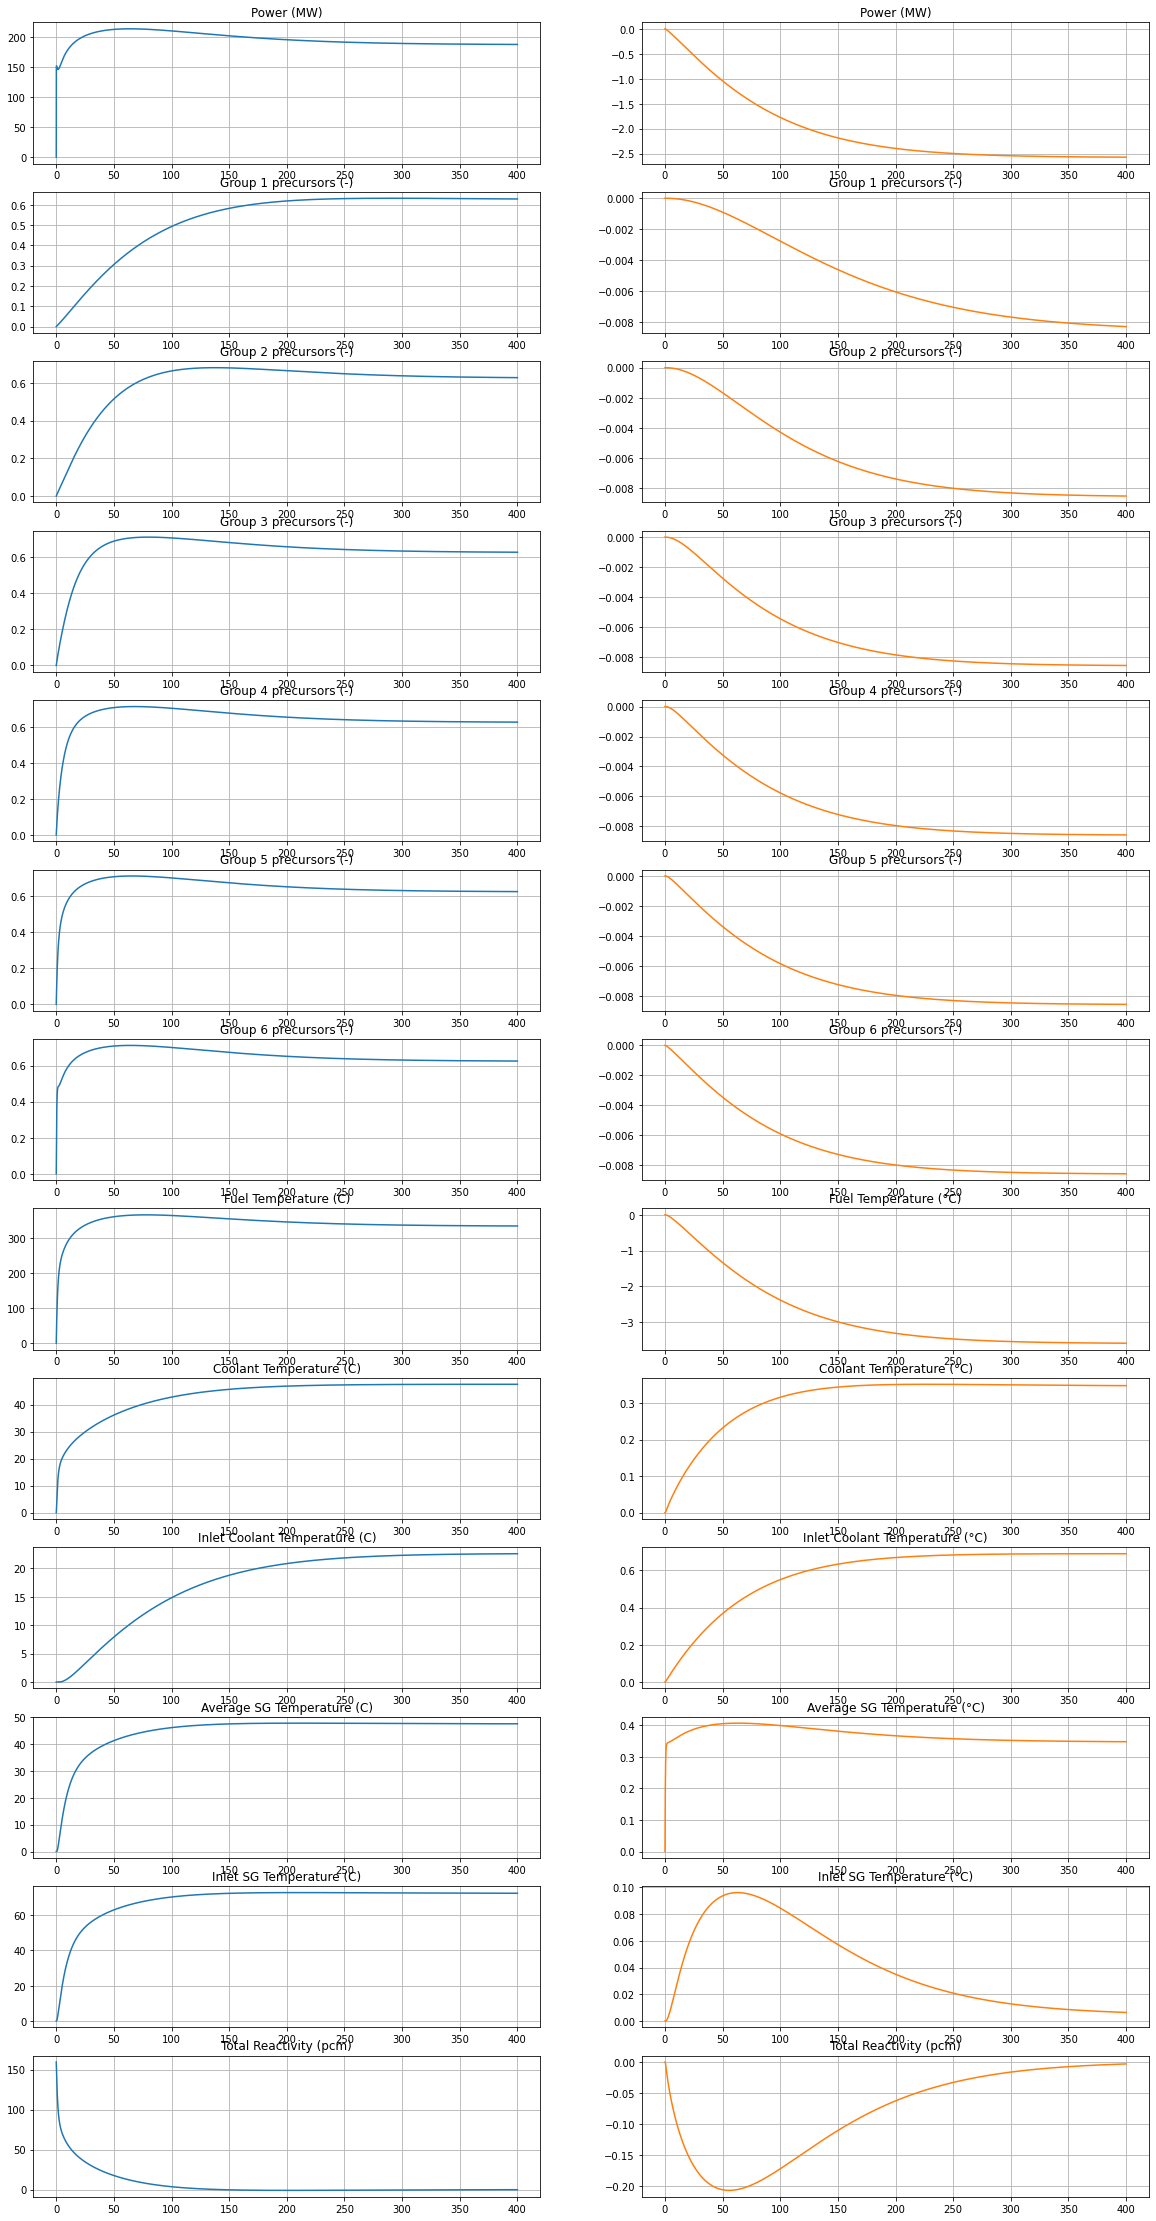

In [ ]:
fig, axs = plt.subplots(13, 2, figsize = (20, 40))

axs[0, 0].plot(t, Y_RhoCL[:,0] *P_0/(10**6),)
axs[0, 0].set_title('Power (MW)')
axs[0, 0].grid()
axs[1, 0].plot(t, Y_RhoCL[:,1],)
axs[1, 0].set_title('Group 1 precursors (-)')
axs[1, 0].grid()
axs[2, 0].plot(t, Y_RhoCL[:,2], )
axs[2, 0].set_title('Group 2 precursors (-)')
axs[2, 0].grid()
axs[3, 0].plot(t, Y_RhoCL[:,3])
axs[3, 0].set_title('Group 3 precursors (-)')
axs[3, 0].grid()
axs[4, 0].plot(t, Y_RhoCL[:,4],)
axs[4, 0].set_title('Group 4 precursors (-)')
axs[4, 0].grid()
axs[5, 0].plot(t, Y_RhoCL[:,5], )
axs[5, 0].set_title('Group 5 precursors (-)')
axs[5, 0].grid()
axs[6, 0].plot(t, Y_RhoCL[:,6], )
axs[6, 0].set_title('Group 6 precursors (-)')
axs[6, 0].grid()
axs[7, 0].plot(t, Y_RhoCL[:,7], )
axs[7, 0].set_title('Fuel Temperature (C)')
axs[7, 0].grid()
axs[8, 0].plot(t, Y_RhoCL[:,8],)
axs[8, 0].set_title('Coolant Temperature (C)')
axs[8, 0].grid()
axs[9, 0].plot(t, Y_RhoCL[:,9],)
axs[9, 0].set_title('Inlet Coolant Temperature (C)')
axs[9, 0].grid()
axs[10, 0].plot(t, Y_RhoCL[:,10],)
axs[10, 0].set_title('Average SG Temperature (C)')
axs[10, 0].grid()
axs[11, 0].plot(t, Y_RhoCL[:,11],)
axs[11, 0].set_title('Inlet SG Temperature (C)')
axs[11, 0].grid()
axs[12, 0].plot(t, Y_RhoCL[:,12]*10**5, )
axs[12, 0].set_title('Total Reactivity (pcm)')
axs[12, 0].grid()

axs[0, 1].plot(t, Y_TinCL[:,0]*P_0/(10**6), 'tab:orange')
axs[0, 1].set_title('Power (MW)')
axs[0, 1].grid()
axs[1, 1].plot(t, Y_TinCL[:,1], 'tab:orange')
axs[1, 1].set_title('Group 1 precursors (-)')
axs[1, 1].grid()
axs[2, 1].plot(t, Y_TinCL[:,2], 'tab:orange')
axs[2, 1].set_title('Group 2 precursors (-)')
axs[2, 1].grid()
axs[3, 1].plot(t, Y_TinCL[:,3], 'tab:orange')
axs[3, 1].set_title('Group 3 precursors (-)')
axs[3, 1].grid()
axs[4, 1].plot(t, Y_TinCL[:,4], 'tab:orange')
axs[4, 1].set_title('Group 4 precursors (-)')
axs[4, 1].grid()
axs[5, 1].plot(t, Y_TinCL[:,5], 'tab:orange')
axs[5, 1].set_title('Group 5 precursors (-)')
axs[5, 1].grid()
axs[6, 1].plot(t, Y_TinCL[:,6], 'tab:orange')
axs[6, 1].set_title('Group 6 precursors (-)')
axs[6, 1].grid()
axs[7, 1].plot(t, Y_TinCL[:,7], 'tab:orange')
axs[7, 1].set_title('Fuel Temperature (°C)')
axs[7, 1].grid()
axs[8, 1].plot(t, Y_TinCL[:,8], 'tab:orange')
axs[8, 1].set_title('Coolant Temperature (°C)')
axs[8, 1].grid()
axs[9, 1].plot(t, Y_TinCL[:,9], 'tab:orange')
axs[9, 1].set_title('Inlet Coolant Temperature (°C)')
axs[9, 1].grid()
axs[10, 1].plot(t, Y_TinCL[:,10], 'tab:orange')
axs[10, 1].set_title('Average SG Temperature (°C)')
axs[10, 1].grid()
axs[11, 1].plot(t, Y_TinCL[:,11], 'tab:orange')
axs[11, 1].set_title('Inlet SG Temperature (°C)')
axs[11, 1].grid()
axs[12, 1].plot(t, Y_TinCL[:,12]*10**5, 'tab:orange')
axs[12, 1].set_title('Total Reactivity (pcm)')
axs[12, 1].grid()

Dominant eigenvalues: -0.012964266462490626


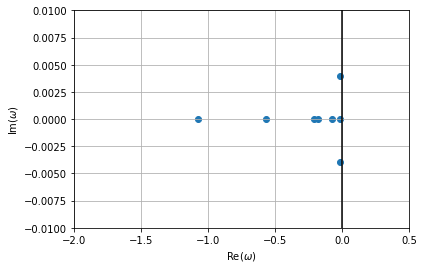

In [ ]:
# Eigenvalues computation

Eigenvaluescl = np.linalg.eigvals(Acl)

print("Dominant eigenvalues: " + str(max(np.real(Eigenvaluescl))))

plt.scatter(np.real(Eigenvaluescl),np.imag(Eigenvaluescl))
plt.xlabel(f'Re($\omega$)')
plt.ylabel(f'Im($\omega$)')
plt.xlim(-2, 0.5)
plt.ylim(-0.01, 0.01)
plt.vlines(0,-0.01, 0.01)
plt.grid()

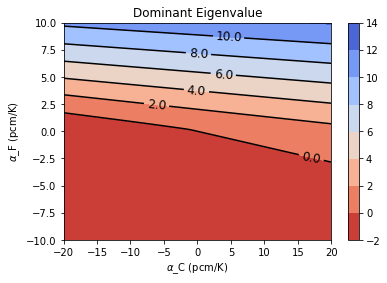

In [ ]:
# Stability map (Alpha_Fuel / Alpha_Cool)

M = 400
N = 400

X = np.zeros(M)
Y = np.zeros(N)
Map = np.zeros((M, N))

Alpha_F = np.linspace(-0.0001,0.0001,M) 
Alpha_C = np.linspace(-0.0002,0.0002,N) 


for AF in range(0, M):
  for AC in range(0, N):
    X[AC] = Alpha_C[AC] * 10 ** 5
    Y[AF] = Alpha_F[AF] * 10 ** 5

    A_TempCL = np.array([
    [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda,  Alpha_F[AF]/Lambda, Alpha_C[AC]/Lambda, 0, 0, 0], #Power density equation
    [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
    [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 2
    [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 3 
    [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 4
    [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0, 0, 0, 0], #Precursor density equation 5
    [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0, 0, 0, 0], #Precursor density equation 6
    [P_0/(M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel, 0, 0, 0], #Fuel temperature equation
    [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, - 1/Tau_Cool - 2/Tau_0, 0, 0, 2/Tau_0], #Coolant temperature equation
    [0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_HL, - 1/Tau_HL, 0, - 1/Tau_HL], # T SG in
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_1, - 1/Tau_SG - 2/Tau_1, 0], # T SG
    [0, 0, 0, 0, 0, 0, 0, 0, 0, - 1/Tau_CL, 2/Tau_CL, -1/Tau_CL] # T C in
    ])

    Eigen = np.linalg.eigvals(A_TempCL)
    MaxEigenCL = np.max(np.real(Eigen))
    Map[AF,AC] = MaxEigenCL

plt.figure()
levels = [0, 2, 4, 6, 8, 10]
contour = plt.contour(X, Y, Map, levels, colors = 'black')
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
contour_filled = plt.contourf(X, Y, Map, cmap='coolwarm_r');
plt.colorbar(contour_filled);
plt.title('Dominant Eigenvalue');
plt.xlabel(r'$\alpha$_C (pcm/K)');
plt.ylabel(r'$\alpha$_F (pcm/K)');

As you see, the Dominant Eigenvalue dependency on the $\alpha_F$ and $\alpha_C$ has changed.

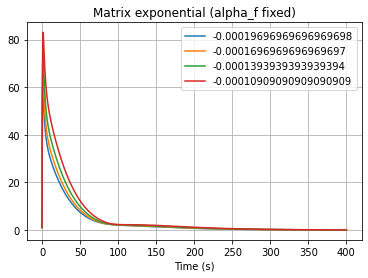

In [ ]:
# Transient exponential matrix

Alpha_Fc = np.linspace(-0.0001,-0.00005,100) 
Alpha_Cc = np.linspace(-0.0002,0.0001,100) 
tcoarse = np.linspace(t_0,t_F,1000)

MatrixExpAC = np.zeros((len(Alpha_Cc),len(tcoarse)))

for AC in range(0, len(Alpha_Cc)):
    A_TempCL = np.array([
    [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda,  Alpha_Fuel/Lambda, Alpha_Cc[AC]/Lambda, 0, 0, 0], #Power density equation
    [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
    [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 2
    [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 3 
    [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 4
    [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0, 0, 0, 0], #Precursor density equation 5
    [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0, 0, 0, 0], #Precursor density equation 6
    [P_0/(M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel, 0, 0, 0], #Fuel temperature equation
    [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, - 1/Tau_Cool - 2/Tau_0, 0, 0, 2/Tau_0], #Coolant temperature equation
    [0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_HL, - 1/Tau_HL, 0, - 1/Tau_HL], # T SG in
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_1, - 1/Tau_SG - 2/Tau_1, 0], # T SG
    [0, 0, 0, 0, 0, 0, 0, 0, 0, - 1/Tau_CL, 2/Tau_CL, -1/Tau_CL] # T C in
    ])


    for j in range(0,len(tcoarse)):
      MatrixExpAC[AC,j] = np.linalg.norm(linalg.expm(A_TempCL*tcoarse[j]),2)

plt.plot(tcoarse,MatrixExpAC[1,:],label = str(Alpha_Cc[1]))
plt.plot(tcoarse,MatrixExpAC[10,:],label = str(Alpha_Cc[10]))
plt.plot(tcoarse,MatrixExpAC[20,:],label = str(Alpha_Cc[20]))
plt.plot(tcoarse,MatrixExpAC[30,:],label = str(Alpha_Cc[30]))
plt.xlabel('Time (s)')
plt.title(f'Matrix exponential (alpha_f fixed)')
plt.grid()
plt.legend()

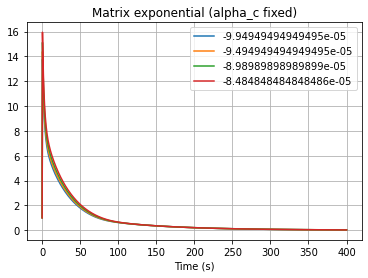

In [ ]:
MatrixExpAF = np.zeros((len(Alpha_Fc),len(tcoarse)))

for AF in range(0, len(Alpha_Fc)):
    A_TempCLf = np.array([
    [-BetaT/Lambda, Beta[0]/Lambda, Beta[1]/Lambda, Beta[2]/Lambda, Beta[3]/Lambda, Beta[4]/Lambda, Beta[5]/Lambda,  Alpha_Fc[AF]/Lambda, Alpha_Cool/Lambda, 0, 0, 0], #Power density equation
    [LambdaI[0], -LambdaI[0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 1
    [LambdaI[1], 0, -LambdaI[1], 0, 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 2
    [LambdaI[2], 0, 0, -LambdaI[2], 0, 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 3 
    [LambdaI[3], 0, 0, 0, -LambdaI[3], 0, 0, 0, 0, 0, 0, 0], #Precursor density equation 4
    [LambdaI[4], 0, 0, 0, 0, -LambdaI[4], 0, 0, 0, 0, 0, 0], #Precursor density equation 5
    [LambdaI[5], 0, 0, 0, 0, 0, -LambdaI[5], 0, 0, 0, 0, 0], #Precursor density equation 6
    [P_0/(M_Fuel * C_Fuel), 0, 0, 0, 0, 0, 0, -1/Tau_Fuel, 1/Tau_Fuel, 0, 0, 0], #Fuel temperature equation
    [0, 0, 0, 0, 0, 0, 0, 1/Tau_Cool, - 1/Tau_Cool - 2/Tau_0, 0, 0, 2/Tau_0], #Coolant temperature equation
    [0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_HL, - 1/Tau_HL, 0, - 1/Tau_HL], # T SG in
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2/Tau_1, - 1/Tau_SG - 2/Tau_1, 0], # T SG
    [0, 0, 0, 0, 0, 0, 0, 0, 0, - 1/Tau_CL, 2/Tau_CL, -1/Tau_CL] # T C in
    ])


    for j in range(0,len(tcoarse)):
      MatrixExpAF[AF,j] = np.linalg.norm(linalg.expm(A_TempCLf*tcoarse[j]),2)

plt.plot(tcoarse,MatrixExpAF[1,:],label = str(Alpha_Fc[1]))
plt.plot(tcoarse,MatrixExpAF[10,:],label = str(Alpha_Fc[10]))
plt.plot(tcoarse,MatrixExpAF[20,:],label = str(Alpha_Fc[20]))
plt.plot(tcoarse,MatrixExpAF[30,:],label = str(Alpha_Fc[30]))
plt.xlabel('Time (s)')
plt.title(f'Matrix exponential (alpha_c fixed)')
plt.grid()
plt.legend()

# Comparison of the Power with Open and Closed loops:

* Linear model:

Closed loop - with the SG

Open loop - without

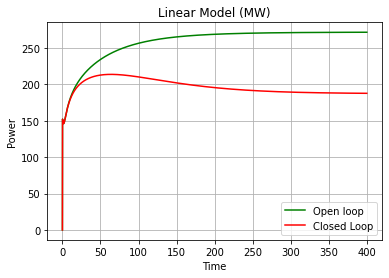

In [ ]:
plt.plot(t, Y_Rho[:,0] *P_0/(10**6), color='g', label='Open loop') #Without SG
plt.plot(t, Y_RhoCL[:,0] *P_0/(10**6), color='r', label='Closed Loop') # With SG

plt.xlabel("Time")
plt.ylabel("Power")
plt.title("Linear Model (MW)")
plt.grid()
plt.legend()




* Non-Linear model:

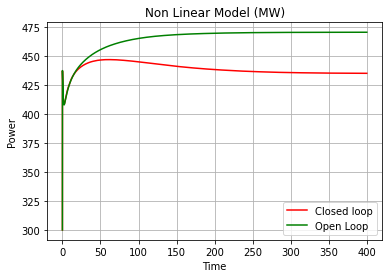

In [ ]:
plt.plot(SolutionNLM.t, SolutionNLM.y[0]*10**-6, color='r', label='Closed loop') #With SG
plt.plot(Solution.t, Solution.y[0]*10**-6, color='g', label='Open Loop') # Without SG

plt.xlabel("Time")
plt.ylabel("Power")
plt.title("Non Linear Model (MW)")
plt.grid()
plt.legend()


# Point 8

The verification between the transient behaviour and the stability map. Try to implement this (with the goal of plotting the power transient for significant values of (αf,αc) and if the system is stable / unstable

I will do that for Non_linear model: 

Values of feedback coefficients:

\begin{equation}
\alpha_f = 2.5 pcm\\
\alpha_c = 2.5 pcm
\end{equation}

Fuel feedback coefficient: -1.929e-06
Coolant feedback coefficient: -2.0008000000000002e-05
Saturation temperature: 357
Initial power: 300000000
Reactivity insertion (pcm): 100.0


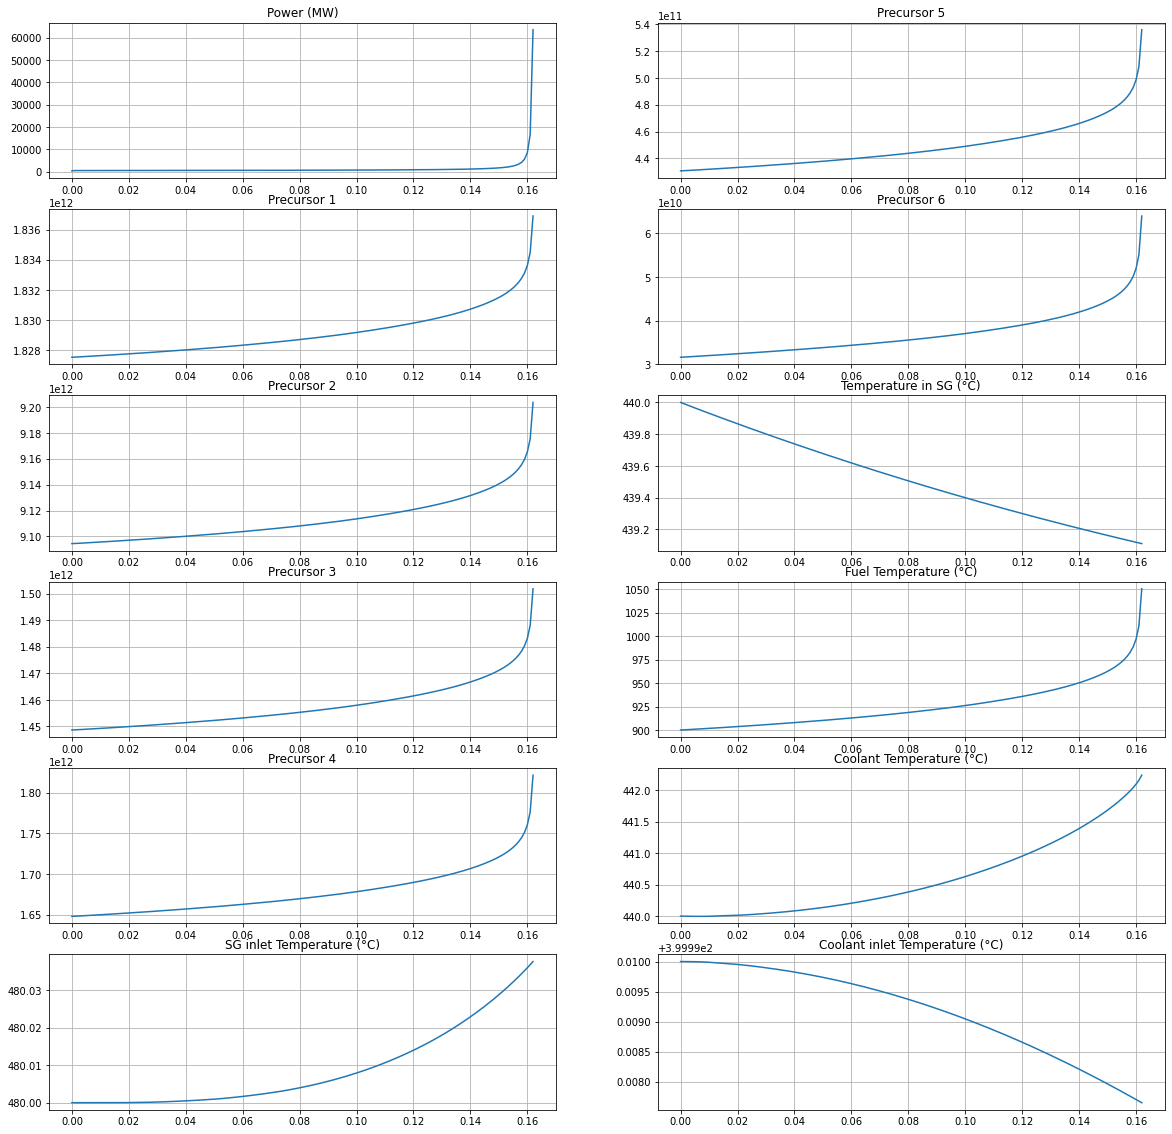

In [ ]:
Alpha_Cool1 = 2.5*10**-5
Alpha_Fuel1 = 2.5*10**-5

# Stationary point

TC0 = T_C
TF0 = T_avF
T_SG0 = TC0
T_SGin = T_Out
T_Cin = T_In

C_1 = P_0 / Lambda * np.divide(Beta[0], LambdaI[0])
C_2 = P_0 / Lambda * np.divide(Beta[1], LambdaI[1])
C_3 = P_0 / Lambda * np.divide(Beta[2], LambdaI[2])
C_4 = P_0 / Lambda * np.divide(Beta[3], LambdaI[3])
C_5 = P_0 / Lambda * np.divide(Beta[4], LambdaI[4])
C_6 = P_0 / Lambda * np.divide(Beta[5], LambdaI[5])

#y_0 = [ 1 ,  1,   1,   1,   1,   1,   1,  TF0, TC0, T_SGin, T_SG0, T_Cin] 
y_0 = [P_0, C_1, C_2, C_3, C_4, C_5, C_6, TF0, TC0, T_SGin, T_SG0, T_Cin] 
#       0    1    2    3    4    5    6    7    8     9       10     11
# Input
Rho_0 = 0
Rho_ext = 100*10**-5                                                           
U = [Rho_ext, T_sat]

t_end = 400
tnew = np.arange(0,t_end, 10**-3)

# Model

def NonLinearModel(t,y):
    dPdt = (U[0] + Alpha_Fuel1*(y[7]-y_0[7]) + Alpha_Cool1*(y[8]-y_0[8]) - BetaT)*y[0]/Lambda + LambdaI[0]*y[1]+LambdaI[1]*y[2]+LambdaI[2]*y[3]+LambdaI[3]*y[4]+LambdaI[4]*y[5]+LambdaI[5]*y[6]
    dC1dt = (Beta[0]/Lambda)*y[0] - LambdaI[0]*y[1]
    dC2dt = (Beta[1]/Lambda)*y[0] - LambdaI[1]*y[2]
    dC3dt = (Beta[2]/Lambda)*y[0] - LambdaI[2]*y[3]
    dC4dt = (Beta[3]/Lambda)*y[0] - LambdaI[3]*y[4]
    dC5dt = (Beta[4]/Lambda)*y[0] - LambdaI[4]*y[5]
    dC6dt = (Beta[5]/Lambda)*y[0] - LambdaI[5]*y[6]
    dTfdt = y[0]/(M_Fuel*C_Fuel) - K*(y[7]-y[8])/(M_Fuel*C_Fuel)
    dTcdt = K*(y[7]-y[8])/(M_Cool*C_Cool) - 2*G_Core*(y[8]- y[11])/(M_Cool)
    dTSG_indt = (2*y[8] - y[11] - y[9])/Tau_HL
    dTSGdt = (-Ksg*(y[10]-U[1]) - 2 * G_Core * C_Cool * (y[10] - y[9]))/(M_SG*C_Cool)
    dTC_indt = (2*y[10] - y[9] - y[11])/Tau_CL
    dYdt = [dPdt,dC1dt,dC2dt,dC3dt,dC4dt,dC5dt,dC6dt,dTfdt,dTcdt, dTSG_indt, dTSGdt, dTC_indt]
    return dYdt

SolutionNLM = solve_ivp(NonLinearModel, [t_0,t_end], y_0, method = 'BDF',t_eval = tnew)

print("Fuel feedback coefficient: " + str(Alpha_Fuel))
print("Coolant feedback coefficient: " + str(Alpha_Cool))
print("Saturation temperature: " + str(T_sat))
print("Initial power: " + str(P_0))
print("Reactivity insertion (pcm): " + str(U[0]*10**5))

fig, axs = plt.subplots(6, 2, figsize = (20, 20))

axs[0, 0].plot(SolutionNLM.t, SolutionNLM.y[0]*10**-6)
axs[0, 0].set_title('Power (MW)')
axs[0, 0].grid()
axs[1, 0].plot(SolutionNLM.t, SolutionNLM.y[1])
axs[1, 0].set_title('Precursor 1')
axs[1, 0].grid()
axs[2, 0].plot(SolutionNLM.t, SolutionNLM.y[2])
axs[2, 0].set_title('Precursor 2')
axs[2, 0].grid()
axs[3, 0].plot(SolutionNLM.t, SolutionNLM.y[3])
axs[3, 0].set_title('Precursor 3')
axs[3, 0].grid()
axs[4, 0].plot(SolutionNLM.t, SolutionNLM.y[4])
axs[4, 0].set_title('Precursor 4')
axs[4, 0].grid()
axs[5, 0].plot(SolutionNLM.t, SolutionNLM.y[9])
axs[5, 0].set_title('SG inlet Temperature (°C)')
axs[5, 0].grid()
axs[0, 1].plot(SolutionNLM.t, SolutionNLM.y[5])
axs[0, 1].set_title('Precursor 5')
axs[0, 1].grid()
axs[1, 1].plot(SolutionNLM.t, SolutionNLM.y[6])
axs[1, 1].set_title('Precursor 6')
axs[1, 1].grid()
axs[2, 1].plot(SolutionNLM.t, SolutionNLM.y[10])
axs[2, 1].set_title('Temperature in SG (°C)')
axs[2, 1].grid()
axs[3, 1].plot(SolutionNLM.t, SolutionNLM.y[7])
axs[3, 1].set_title('Fuel Temperature (°C)')
axs[3, 1].grid()
axs[4, 1].plot(SolutionNLM.t, SolutionNLM.y[8])
axs[4, 1].set_title('Coolant Temperature (°C)')
axs[4, 1].grid()
axs[5, 1].plot(SolutionNLM.t, SolutionNLM.y[11])
axs[5, 1].set_title('Coolant inlet Temperature (°C)')
axs[5, 1].grid()